## Imports and Function Definitions

In [1]:
import yaml, glob
import pandas as pd
from sklearn.model_selection import train_test_split, GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
import tqdm
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from callbacks import get_callbacks 
import logging
from sklearn.utils import class_weight

In [2]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    # plt.xlim(-0.5, len(np.unique(y))-0.5)
    # plt.ylim(len(np.unique(y))-0.5, -0.5)
    return ax

def one_hot(x):
    a = np.zeros(len(output_cols))
    a[x] = 1
    return a

def build_model(input_size, hidden_size, output_size):
    model = tf.keras.models.Sequential(
        [tf.keras.layers.Dense(input_size, activation='relu'),
        tf.keras.layers.Dense(hidden_size, activation='relu'),
        tf.keras.layers.Dense(output_size, activation='softmax')]
    )
    return model

# NN for all ASOS Data

This model will be a simple NN consisting only of Keras dense layers.

### Get features and outputs from config.yml

In [3]:
config = 'config.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)
    
# print(conf)
input_cols = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
output_cols = conf['outputvars']

In [4]:
# sort files by their date
arr = sorted(glob.glob(conf['asos_path']+'*'))

### Load all ASOS data

In [5]:
df = pd.concat([pd.read_parquet(x) for x in tqdm.tqdm(arr)])
df.shape

100%|██████████| 1884/1884 [03:44<00:00,  8.39it/s]


(4029725, 407)

### Split the data

In [6]:
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])

In [7]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.9)

In [8]:
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]

In [9]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.885)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]

In [10]:
train_data.shape

(3246577, 408)

In [11]:
test_data.shape

(420210, 408)

In [12]:
valid_data.shape

(362938, 408)

### Preprocess the data

In [13]:
scaler_x = StandardScaler()

In [14]:
x_train = scaler_x.fit_transform(train_data[input_cols])

In [15]:
x_valid = scaler_x.transform(valid_data[input_cols])

In [16]:
x_test = scaler_x.transform(test_data[input_cols])

In [17]:
train_data['label'] = train_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_train = train_data['label'].to_numpy()
y_train = np.vstack(y_train)

In [18]:
valid_data['label'] = valid_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_valid = valid_data['label'].to_numpy()
y_valid = np.vstack(y_valid)

In [19]:
test_data['label'] = test_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_test = test_data['label'].to_numpy()
y_test = np.vstack(y_test)

/glade/scratch/jwillson/ipykernel_127668/4158757772.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = test_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))


### Train Model

In [32]:
model = build_model(len(input_cols), 100, len(output_cols))
model.build((20000, len(input_cols)))
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (20000, 268)              72092     
                                                                 
 dense_13 (Dense)            (20000, 100)              26900     
                                                                 
 dense_14 (Dense)            (20000, 4)                404       
                                                                 
Total params: 99,396
Trainable params: 99,396
Non-trainable params: 0
_________________________________________________________________


In [33]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics='acc', run_eagerly=True) 
#metrics could be list

In [35]:
training = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), batch_size=20000, shuffle=True, epochs=25) 
#set as variable

Epoch 1/25
163/163 [==============================] - 26s 156ms/step - loss: 0.1228 - acc: 0.9549 - val_loss: 0.1270 - val_acc: 0.9526
Epoch 2/25
163/163 [==============================] - 25s 154ms/step - loss: 0.1185 - acc: 0.9564 - val_loss: 0.1275 - val_acc: 0.9518
Epoch 3/25
163/163 [==============================] - 25s 153ms/step - loss: 0.1149 - acc: 0.9577 - val_loss: 0.1241 - val_acc: 0.9537
Epoch 4/25
163/163 [==============================] - 25s 156ms/step - loss: 0.1126 - acc: 0.9586 - val_loss: 0.1212 - val_acc: 0.9548
Epoch 5/25
163/163 [==============================] - 25s 156ms/step - loss: 0.1101 - acc: 0.9594 - val_loss: 0.1225 - val_acc: 0.9540
Epoch 6/25
163/163 [==============================] - 25s 153ms/step - loss: 0.1084 - acc: 0.9600 - val_loss: 0.1183 - val_acc: 0.9555
Epoch 7/25
163/163 [==============================] - 26s 158ms/step - loss: 0.1069 - acc: 0.9607 - val_loss: 0.1183 - val_acc: 0.9557
Epoch 8/25
163/163 [==============================] - 2

### Test Model

In [36]:
predictions = model.predict(x_test)

In [37]:
preds = np.argmax(predictions, 1)
labels = np.argmax(y_test,1)
(preds == labels).mean()

0.9575283786678089

Confusion matrix, without normalization
[[290082   6266      7    786]
 [  6452 109901      7   1180]
 [   184    179      2     81]
 [  1406   1296      3   2378]]
Normalized confusion matrix
[[9.76e-01 2.11e-02 2.36e-05 2.65e-03]
 [5.49e-02 9.35e-01 5.96e-05 1.00e-02]
 [4.13e-01 4.01e-01 4.48e-03 1.82e-01]
 [2.77e-01 2.55e-01 5.90e-04 4.68e-01]]


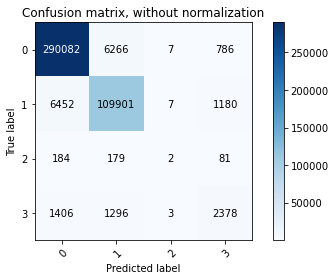

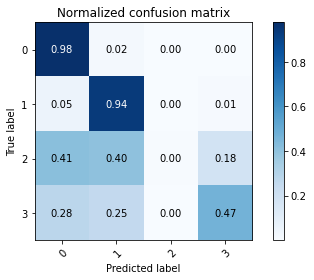

In [39]:
np.set_printoptions(precision=2)
class_names = [str(x) for x in sorted(set(labels))]

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

# New NN

New features

- 4 callbacks in the config.yml file are used with John's default settings
- one hot encoding removed so the model can predict the percentages of each ptype

Planning on introducing a weighting scheme based on the proportions for each class label in the training dataset. 

### Get features and outputs from config.yml

In [3]:
config = 'config.yml'
with open(config) as f:
    conf = yaml.load(f, Loader=yaml.FullLoader)
    
# print(conf)
input_cols = conf['tempvars'] + conf['tempdewvars'] + conf['ugrdvars'] + conf['vgrdvars']
output_cols = conf['outputvars']

In [4]:
# sort files by their date
arr = sorted(glob.glob(conf['asos_path']+'*'))

### Load all ASOS data

In [5]:
df = pd.read_parquet(conf['work_path']+'asos_data.parquet')

In [5]:
df = pd.concat([pd.read_parquet(x) for x in tqdm.tqdm(arr)])
df.shape

100%|██████████| 1884/1884 [03:48<00:00,  8.26it/s]


(4029725, 407)

In [17]:
df.to_parquet(conf['work_path']+'asos_data.parquet')

### Split the data

In [25]:
df['day'] = df['datetime'].apply(lambda x: str(x).split(' ')[0])

In [26]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.9)

In [27]:
train_idx, test_idx = list(splitter.split(df, groups=df['day']))[0]
train_data, test_data = df.iloc[train_idx], df.iloc[test_idx]

In [28]:
splitter = GroupShuffleSplit(n_splits=1, train_size=0.885)
train_idx, valid_idx = list(splitter.split(train_data, groups=train_data['day']))[0]
train_data, valid_data = train_data.iloc[train_idx], train_data.iloc[valid_idx]

In [29]:
train_data.shape

(3201044, 408)

In [30]:
test_data.shape

(393605, 408)

In [31]:
valid_data.shape

(435076, 408)

### Preprocess the data

In [32]:
scaler_x = StandardScaler()

In [33]:
x_train = scaler_x.fit_transform(train_data[input_cols])

In [34]:
x_valid = scaler_x.transform(valid_data[input_cols])

In [35]:
x_test = scaler_x.transform(test_data[input_cols])

#### One hot encoding

In [36]:
train_data['label'] = train_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_train = train_data['label'].to_numpy()
y_train = np.vstack(y_train)
y_train.shape

(3201044, 4)

In [37]:
valid_data['label'] = valid_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_valid = valid_data['label'].to_numpy()
y_valid = np.vstack(y_valid)
y_valid.shape

(435076, 4)

In [38]:
test_data['label'] = test_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))
y_test = test_data['label'].to_numpy()
y_test = np.vstack(y_test)
y_test.shape

/glade/scratch/jwillson/ipykernel_102308/1794376418.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_data['label'] = test_data[output_cols].idxmax(axis=1).apply(lambda x: one_hot(output_cols.index(x)))


(393605, 4)

#### One hot encoding not used

In [20]:
y_train = train_data[output_cols].to_numpy()
y_train.shape

(3195149, 4)

In [21]:
y_valid = valid_data[output_cols].to_numpy()
y_valid.shape

(436901, 4)

In [22]:
y_test = test_data[output_cols].to_numpy()
y_test.shape

(397675, 4)

#### Add class weights

In [72]:
classes = [np.argmax(y_train[i]) for i in range(len(y_train))]

In [73]:
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(classes), y=classes)
class_weights

array([  0.36,   0.86, 222.42,  19.55])

In [74]:
class_weights_dict = {i:class_weights[i] for i in range(4)}
class_weights_dict

{0: 0.3598372548496218,
 1: 0.8581255967761948,
 2: 222.41554809843402,
 3: 19.554457392929145}

### Build Model

In [20]:
model = build_model(len(input_cols), 100, len(output_cols))
model.build((20000, len(input_cols)))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (20000, 268)              72092     
                                                                 
 dense_1 (Dense)             (20000, 100)              26900     
                                                                 
 dense_2 (Dense)             (20000, 4)                404       
                                                                 
Total params: 99,396
Trainable params: 99,396
Non-trainable params: 0
_________________________________________________________________


2022-06-08 10:48:40.688421: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Load model

In [21]:
model.load_weights(conf['work_path']+'asos_mlp3.h5')

### Train Model

In [76]:
learning_rate = 1e-3
optimizer = tf.keras.optimizers.Adam(learning_rate)
loss = tf.keras.losses.CategoricalCrossentropy()
model.compile(loss=loss, optimizer=optimizer, metrics='acc', run_eagerly=True) 
#metrics could be list

In [77]:
callbacks = get_callbacks(conf)
training = model.fit(x_train, y_train, validation_data=(x_valid, y_valid), class_weight=class_weights_dict, callbacks=callbacks,
                     batch_size=20000, shuffle=True, epochs=1000) 
#set as variable

Epoch 1/1000
160/160 [==============================] - 25s 157ms/step - loss: 0.7049 - acc: 0.8026 - val_loss: 0.4378 - val_acc: 0.8392 - lr: 0.0010
Epoch 2/1000
160/160 [==============================] - 25s 154ms/step - loss: 0.5836 - acc: 0.8457 - val_loss: 0.3825 - val_acc: 0.8630 - lr: 0.0010
Epoch 3/1000
160/160 [==============================] - 25s 154ms/step - loss: 0.5476 - acc: 0.8574 - val_loss: 0.3421 - val_acc: 0.8760 - lr: 0.0010
Epoch 4/1000
160/160 [==============================] - 24s 150ms/step - loss: 0.5211 - acc: 0.8653 - val_loss: 0.3933 - val_acc: 0.8568 - lr: 0.0010
Epoch 5/1000
160/160 [==============================] - 25s 155ms/step - loss: 0.5118 - acc: 0.8675 - val_loss: 0.3632 - val_acc: 0.8712 - lr: 0.0010
Epoch 6/1000
160/160 [==============================] - 26s 161ms/step - loss: 0.4632 - acc: 0.8777 - val_loss: 0.3326 - val_acc: 0.8805 - lr: 2.0000e-04
Epoch 7/1000
160/160 [==============================] - 24s 152ms/step - loss: 0.4524 - acc: 0.8

### Test Model

In [39]:
predictions = model.predict(x_test)
predictions

array([[1.00e+00, 4.87e-05, 1.28e-08, 2.23e-06],
       [1.00e+00, 3.82e-04, 5.40e-09, 9.18e-07],
       [1.00e+00, 2.47e-05, 4.22e-09, 4.54e-07],
       ...,
       [5.79e-01, 2.86e-01, 1.34e-01, 1.17e-03],
       [6.35e-01, 2.64e-01, 9.98e-02, 7.07e-04],
       [3.96e-01, 1.57e-02, 5.84e-01, 4.74e-03]], dtype=float32)

In [40]:
preds = np.argmax(predictions, 1)
labels = np.argmax(y_test,1)
(preds == labels).mean()
# acc = [preds[i] == labels[i] for i in range(len(preds))]
# acc.mean()

0.8923844971481562

Confusion matrix, without normalization
[[250910  11256   5969   8657]
 [  4456  96470   4945   5861]
 [     5     16    223     58]
 [   149    476    510   3644]]
Normalized confusion matrix
[[0.91 0.04 0.02 0.03]
 [0.04 0.86 0.04 0.05]
 [0.02 0.05 0.74 0.19]
 [0.03 0.1  0.11 0.76]]


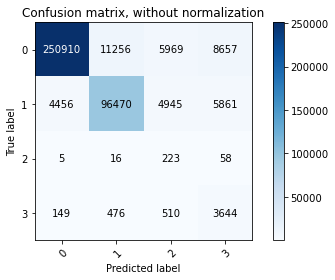

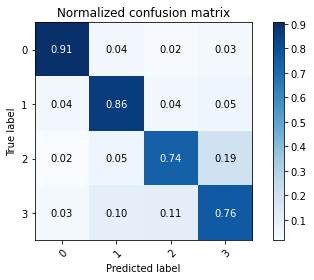

In [41]:
np.set_printoptions(precision=2)
class_names = [str(x) for x in sorted(set(labels))]

# Plot non-normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plot_confusion_matrix(labels, preds, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()